In [83]:
from utils import *
from dataset import *
from constants import *
from models.BaseModels import *
from models.DeepModels import *
from models.DeepUtils import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from dataset import Participant
from torch.utils.data import DataLoader

random.seed(RANDOM_STATE)

# Movement recognition

In [84]:
part_name = 's6'
use_saved = True

In [85]:
if use_saved and os.path.exists(f'saved/{part_name}.pkl'):
    participant = Participant.load_from_pickle(f'saved/{part_name}.pkl')
else:
    participant = Participant(part_name, data_path=DATA_PATH_NOTEBOOK, alpha=ALPHA)
    saved_dir = os.path.join(os.getcwd(), 'saved')
    if not os.path.exists(saved_dir):
        os.makedirs(saved_dir)
    with open(f'saved/{part_name}.pkl', 'wb') as f:
        pickle.dump(participant, f, pickle.HIGHEST_PROTOCOL)

In [86]:
test_size = 0.3
pca_expl_var = 0.95

## Execution

<span style='color: red'>WARNING</span>: computing all features takes around 7 minutes (Intel Core i7-7700K)

In [87]:
if use_saved and os.path.exists(f'saved/ex_features_{part_name}_mvt.h5'):
    ex_features = pd.read_hdf(f'saved/ex_features_{part_name}_mvt.h5', 'df')
else:
    ex_features = participant.get_features_all_sessions_mvt('E')
    ex_features.to_hdf(f'saved/ex_features_{part_name}_mvt.h5', 'df', mode='w', data_columns=True)

In [88]:
print(f'The dataset contains {ex_features.shape[0]} samples and {ex_features.shape[1]} features.')
print(f'The {len(participant.relevant_channels_ex)} relevant channels are located in the following locations:')
regions = [participant.channels_locations[i] for i in [channel.idx for channel in participant.relevant_channels_ex]]
channels_per_regions = {}
for region in set(regions):
    channels_per_regions[region] = regions.count(region)
print(channels_per_regions)

The dataset contains 128 samples and 4897 features.
The 68 relevant channels are located in the following locations:
{'precentral': 26, 'postcentral': 16, 'paracentral': 3, 'WM_insula': 1, 'WM_precentral': 6, 'insula': 3, 'WM_paracentral': 1, 'supramarginal': 3, 'superiorfrontal': 5, 'caudalmiddlefrontal': 4}


Let's create a baseline by taking the same number of channels, but without checking whether they are responsive:

<span style='color: red'>WARNING</span>: computing all features takes around 7 minutes (Intel Core i7-7700K)

In [89]:
if use_saved and os.path.exists(f'saved/ex_baseline_features_{part_name}_mvt.h5'):
    ex_baseline_features = pd.read_hdf(f'saved/ex_baseline_features_{part_name}_mvt.h5', 'df')
else:
    ex_baseline_features = participant.get_features_all_sessions_unresponsive(len(participant.relevant_channels_ex), movtype='E')
    ex_baseline_features.to_hdf(f'saved/ex_baseline_features_{part_name}_mvt.h5', 'df', mode='w', data_columns=True)

In [90]:
print(f'The baseline dataset contains {ex_baseline_features.shape[0]} samples and {ex_baseline_features.shape[1]} features.')

The baseline dataset contains 128 samples and 2737 features.


In [91]:
accuracies_ex = {}
accuracies_ex_baseline = {}

### Train a model on the baseline features (Logistic Regression)

In [92]:
X = ex_baseline_features.drop('label', axis=1)
y = ex_baseline_features['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)

logreg = LogisticRegressionModel()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex_baseline['Logistic Regression'] = accuracy

Accuracy: 0.64


#### With PCA

In [93]:
logreg = LogisticRegressionModel(use_pca=True, expl_var=0.95)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex_baseline['Logistic Regression PCA'] = accuracy

Accuracy: 0.59


### Train a model (SVM)

In [94]:
svm = SVMModel()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex_baseline['SVM'] = accuracy

Accuracy: 0.62


#### With PCA

In [95]:
svm = SVMModel(use_pca=True, expl_var=0.95)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex_baseline['SVM PCA'] = accuracy

Accuracy: 0.56


### Train a model (Random Forest)

In [ ]:
rf = RandomForestModel()
rf.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex_baseline['Random Forest'] = accuracy

Accuracy: 0.67


### Train a model (Multi-Layer Perceptron)

In [97]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [98]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

mlp = MLP(X_train.shape[1], 2, layers=(16, 16))
trainset = DfDataset(X_train, y_train)
valset = DfDataset(X_val, y_val)
train_loader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(valset, batch_size=4, shuffle=False, num_workers=4)

trainer = Trainer(mlp, 0.1, 20, 4, save_path='saved/mlp.pth', device=device)
trainer.train(train_loader, val_loader)

Epoch 1/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  6.54it/s]


Epoch: 1 	Training Loss: 14.516672 	Training Acc: 0.617978


Epoch 1/20 - Validation: 100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


Epoch: 1 	Validation Loss: 2.716201 	Validation Acc: 0.736842
Validation loss decreased (inf --> 2.716201). Saving model ...


Epoch 2/20 - Training: 100%|██████████| 23/23 [00:04<00:00,  5.46it/s]


Epoch: 2 	Training Loss: 8.248876 	Training Acc: 0.528090


Epoch 2/20 - Validation: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch: 2 	Validation Loss: 0.610493 	Validation Acc: 0.421053
Validation loss decreased (2.716201 --> 0.610493). Saving model ...


Epoch 3/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  6.66it/s]


Epoch: 3 	Training Loss: 2.124929 	Training Acc: 0.516854


Epoch 3/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch: 3 	Validation Loss: 1.420714 	Validation Acc: 0.368421


Epoch 4/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  6.63it/s]


Epoch: 4 	Training Loss: 2.692026 	Training Acc: 0.528090


Epoch 4/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch: 4 	Validation Loss: 0.606875 	Validation Acc: 0.684211
Validation loss decreased (0.610493 --> 0.606875). Saving model ...


Epoch 5/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  7.10it/s]


Epoch: 5 	Training Loss: 1.364454 	Training Acc: 0.483146


Epoch 5/20 - Validation: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Epoch: 5 	Validation Loss: 0.697545 	Validation Acc: 0.421053


Epoch 6/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  7.47it/s]


Epoch: 6 	Training Loss: 0.710470 	Training Acc: 0.494382


Epoch 6/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch: 6 	Validation Loss: 0.684691 	Validation Acc: 0.578947


Epoch 7/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  6.99it/s]


Epoch: 7 	Training Loss: 0.698187 	Training Acc: 0.505618


Epoch 7/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch: 7 	Validation Loss: 0.659013 	Validation Acc: 0.631579


Epoch 8/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  7.18it/s]


Epoch: 8 	Training Loss: 0.694527 	Training Acc: 0.494382


Epoch 8/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch: 8 	Validation Loss: 0.672875 	Validation Acc: 0.421053


Epoch 9/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  7.30it/s]


Epoch: 9 	Training Loss: 0.693885 	Training Acc: 0.505618


Epoch 9/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch: 9 	Validation Loss: 0.653788 	Validation Acc: 0.631579


Epoch 10/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  7.04it/s]


Epoch: 10 	Training Loss: 0.693054 	Training Acc: 0.494382


Epoch 10/20 - Validation: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch: 10 	Validation Loss: 0.684086 	Validation Acc: 0.421053


Epoch 11/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  7.60it/s]


Epoch: 11 	Training Loss: 0.696869 	Training Acc: 0.494382


Epoch 11/20 - Validation: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch: 11 	Validation Loss: 0.667298 	Validation Acc: 0.421053


Epoch 12/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  7.52it/s]


Epoch: 12 	Training Loss: 0.691549 	Training Acc: 0.449438


Epoch 12/20 - Validation: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch: 12 	Validation Loss: 0.666326 	Validation Acc: 0.421053


Epoch 13/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  7.56it/s]


Epoch: 13 	Training Loss: 0.695751 	Training Acc: 0.505618


Epoch 13/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch: 13 	Validation Loss: 0.660281 	Validation Acc: 0.631579


Epoch 14/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  6.63it/s]


Epoch: 14 	Training Loss: 0.698377 	Training Acc: 0.460674


Epoch 14/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch: 14 	Validation Loss: 0.681241 	Validation Acc: 0.421053


Epoch 15/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  6.60it/s]


Epoch: 15 	Training Loss: 0.695682 	Training Acc: 0.460674


Epoch 15/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch: 15 	Validation Loss: 0.655147 	Validation Acc: 0.631579


Epoch 16/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  6.95it/s]


Epoch: 16 	Training Loss: 0.686578 	Training Acc: 0.528090


Epoch 16/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch: 16 	Validation Loss: 0.690028 	Validation Acc: 0.421053


Epoch 17/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  6.60it/s]


Epoch: 17 	Training Loss: 0.696088 	Training Acc: 0.449438


Epoch 17/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch: 17 	Validation Loss: 0.658881 	Validation Acc: 0.631579


Epoch 18/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  6.79it/s]


Epoch: 18 	Training Loss: 0.694689 	Training Acc: 0.505618


Epoch 18/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch: 18 	Validation Loss: 0.673616 	Validation Acc: 0.421053


Epoch 19/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  6.63it/s]


Epoch: 19 	Training Loss: 0.705600 	Training Acc: 0.426966


Epoch 19/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch: 19 	Validation Loss: 0.673517 	Validation Acc: 0.421053


Epoch 20/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  6.97it/s]


Epoch: 20 	Training Loss: 0.693288 	Training Acc: 0.483146


Epoch 20/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]

Epoch: 20 	Validation Loss: 0.667781 	Validation Acc: 0.421053


In [99]:
testset = DfDataset(X_test, y_test)
acc = 0
for input, label in testset:
    pred = trainer.model(input)
    if torch.argmax(pred) == label:
        acc += 1

acc /= len(testset)
print(f"Accuracy: {acc:.2f}")

accuracies_ex_baseline['MLP'] = acc

Accuracy: 0.55


## Let's now do the analysis for the responsive channels

In [100]:
X = ex_features.drop('label', axis=1)
y = ex_features['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)

### Train a model (Logistic Regression)

In [101]:
logreg = LogisticRegressionModel()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex['Logistic Regression'] = accuracy

Accuracy: 0.77


#### With PCA

In [102]:
logreg = LogisticRegressionModel(use_pca=True, expl_var=0.95)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex['Logistic Regression PCA'] = accuracy

Accuracy: 0.69


### Train a model (SVM)

In [103]:
svm = SVMModel()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex['SVM'] = accuracy

Accuracy: 0.62


#### With PCA

In [104]:
svm = SVMModel(use_pca=True, expl_var=0.95)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex['SVM PCA'] = accuracy

Accuracy: 0.56


### Train a model (Random Forest)

In [105]:
rf = RandomForestModel()
rf.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex['Random Forest'] = accuracy

Accuracy: 0.62


### Train a model (Multi-Layer Perceptron)

In [106]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [107]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

mlp = MLP(X_train.shape[1], 2, layers=(16, 16))
trainset = DfDataset(X_train, y_train)
valset = DfDataset(X_val, y_val)
train_loader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(valset, batch_size=4, shuffle=False, num_workers=4)

trainer = Trainer(mlp, 0.1, 20, 4, save_path='saved/mlp.pth', device=device)
trainer.train(train_loader, val_loader)

Epoch 1/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  7.53it/s]


Epoch: 1 	Training Loss: 12.305841 	Training Acc: 0.516854


Epoch 1/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch: 1 	Validation Loss: 1.979212 	Validation Acc: 0.578947
Validation loss decreased (inf --> 1.979212). Saving model ...


Epoch 2/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  6.41it/s]


Epoch: 2 	Training Loss: 2.921434 	Training Acc: 0.460674


Epoch 2/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch: 2 	Validation Loss: 6.292884 	Validation Acc: 0.421053


Epoch 3/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  6.45it/s]


Epoch: 3 	Training Loss: 1.145042 	Training Acc: 0.505618


Epoch 3/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch: 3 	Validation Loss: 0.692600 	Validation Acc: 0.578947
Validation loss decreased (1.979212 --> 0.692600). Saving model ...


Epoch 4/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  6.13it/s]


Epoch: 4 	Training Loss: 2.015843 	Training Acc: 0.438202


Epoch 4/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch: 4 	Validation Loss: 0.695757 	Validation Acc: 0.421053


Epoch 5/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  6.44it/s]


Epoch: 5 	Training Loss: 0.703137 	Training Acc: 0.415730


Epoch 5/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch: 5 	Validation Loss: 0.699267 	Validation Acc: 0.421053


Epoch 6/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  6.71it/s]


Epoch: 6 	Training Loss: 0.699010 	Training Acc: 0.471910


Epoch 6/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch: 6 	Validation Loss: 0.687409 	Validation Acc: 0.578947
Validation loss decreased (0.692600 --> 0.687409). Saving model ...


Epoch 7/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  6.83it/s]


Epoch: 7 	Training Loss: 0.694778 	Training Acc: 0.505618


Epoch 7/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Epoch: 7 	Validation Loss: 0.709042 	Validation Acc: 0.421053


Epoch 8/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  6.11it/s]


Epoch: 8 	Training Loss: 0.698857 	Training Acc: 0.426966


Epoch 8/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch: 8 	Validation Loss: 0.694756 	Validation Acc: 0.421053


Epoch 9/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  6.45it/s]


Epoch: 9 	Training Loss: 0.699143 	Training Acc: 0.438202


Epoch 9/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch: 9 	Validation Loss: 0.710435 	Validation Acc: 0.421053


Epoch 10/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  6.22it/s]


Epoch: 10 	Training Loss: 0.706482 	Training Acc: 0.426966


Epoch 10/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch: 10 	Validation Loss: 0.694220 	Validation Acc: 0.421053


Epoch 11/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  6.58it/s]


Epoch: 11 	Training Loss: 0.707280 	Training Acc: 0.494382


Epoch 11/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch: 11 	Validation Loss: 0.689683 	Validation Acc: 0.578947


Epoch 12/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  6.51it/s]


Epoch: 12 	Training Loss: 0.696879 	Training Acc: 0.382022


Epoch 12/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch: 12 	Validation Loss: 0.695325 	Validation Acc: 0.421053


Epoch 13/20 - Training: 100%|██████████| 23/23 [00:04<00:00,  5.53it/s]


Epoch: 13 	Training Loss: 0.698394 	Training Acc: 0.505618


Epoch 13/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch: 13 	Validation Loss: 0.699487 	Validation Acc: 0.421053


Epoch 14/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  6.41it/s]


Epoch: 14 	Training Loss: 0.706306 	Training Acc: 0.471910


Epoch 14/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch: 14 	Validation Loss: 0.683349 	Validation Acc: 0.578947
Validation loss decreased (0.687409 --> 0.683349). Saving model ...


Epoch 15/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  6.48it/s]


Epoch: 15 	Training Loss: 0.703765 	Training Acc: 0.483146


Epoch 15/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch: 15 	Validation Loss: 0.693498 	Validation Acc: 0.421053


Epoch 16/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  6.56it/s]


Epoch: 16 	Training Loss: 0.698093 	Training Acc: 0.505618


Epoch 16/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch: 16 	Validation Loss: 0.701135 	Validation Acc: 0.421053


Epoch 17/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  6.42it/s]


Epoch: 17 	Training Loss: 0.698526 	Training Acc: 0.505618


Epoch 17/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch: 17 	Validation Loss: 0.705534 	Validation Acc: 0.421053


Epoch 18/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  6.67it/s]


Epoch: 18 	Training Loss: 0.699541 	Training Acc: 0.516854


Epoch 18/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch: 18 	Validation Loss: 0.690644 	Validation Acc: 0.578947


Epoch 19/20 - Training: 100%|██████████| 23/23 [00:03<00:00,  5.87it/s]


Epoch: 19 	Training Loss: 0.705546 	Training Acc: 0.460674


Epoch 19/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch: 19 	Validation Loss: 0.720988 	Validation Acc: 0.421053


Epoch 20/20 - Training: 100%|██████████| 23/23 [00:04<00:00,  5.70it/s]


Epoch: 20 	Training Loss: 0.710190 	Training Acc: 0.449438


Epoch 20/20 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]

Epoch: 20 	Validation Loss: 0.688218 	Validation Acc: 0.578947


In [108]:
testset = DfDataset(X_test, y_test)
acc = 0
for input, label in testset:
    pred = trainer.model(input)
    if torch.argmax(pred) == label:
        acc += 1

acc /= len(testset)
print(f"Accuracy: {acc:.2f}")

accuracies_ex['MLP'] = acc

Accuracy: 0.45


## Observation

<span style='color: red'>WARNING</span>: computing all features takes around 7 minutes (Intel Core i7-7700K)

In [109]:
if use_saved and os.path.exists(f'saved/obs_features_{part_name}_mvt.h5'):
    obs_features = pd.read_hdf(f'saved/obs_features_{part_name}_mvt.h5', 'df')
else:
    obs_features = participant.get_features_all_sessions_mvt('O')
    obs_features.to_hdf(f'saved/obs_features_{part_name}_mvt.h5', 'df', mode='w', data_columns=True)

In [110]:
print(f'The dataset contains {obs_features.shape[0]} samples and {obs_features.shape[1]} features.')

The dataset contains 128 samples and 3673 features.


Let's create a baseline by taking the same number of channels, but without checking whether they are responsive:

In [111]:
if use_saved and os.path.exists(f'saved/obs_baseline_features_{part_name}_mvt.h5'):
    obs_baseline_features = pd.read_hdf(f'saved/obs_baseline_features_{part_name}_mvt.h5', 'df')
else:
    obs_baseline_features = participant.get_features_all_sessions_unresponsive(len(participant.relevant_channels_obs), movtype='O')
    obs_baseline_features.to_hdf(f'saved/obs_baseline_features_{part_name}_mvt.h5', 'df', mode='w', data_columns=True)

In [112]:
print(f'The baseline dataset contains {ex_baseline_features.shape[0]} samples and {ex_baseline_features.shape[1]} features.')

The baseline dataset contains 128 samples and 2737 features.


In [113]:
accuracies_obs = {}
accuracies_obs_baseline = {}

### Train a model on the baseline features (Logistic Regression)

In [114]:
X = obs_baseline_features.drop('label', axis=1)
y = obs_baseline_features['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)

logreg = LogisticRegressionModel()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs_baseline['Logistic Regression'] = accuracy

Accuracy: 0.49


#### With PCA

In [115]:
logreg = LogisticRegressionModel(use_pca=True, expl_var=0.95)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs_baseline['Logistic Regression PCA'] = accuracy

Accuracy: 0.49


### Train a model (SVM)

In [116]:
svm = SVMModel()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs_baseline['SVM'] = accuracy

Accuracy: 0.44


#### With PCA

In [117]:
svm = SVMModel(use_pca=True, expl_var=0.95)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs_baseline['SVM PCA'] = accuracy

Accuracy: 0.54


### Train a model (Random Forest)

In [ ]:
rf = RandomForestModel()
rf.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs_baseline['Random Forest'] = accuracy

Accuracy: 0.62


### Train a model (Multi-Layer Perceptron)

In [119]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [120]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

mlp = MLP(X_train.shape[1], 2, layers=(16, 16))
trainset = DfDataset(X_train, y_train)
valset = DfDataset(X_val, y_val)
train_loader = DataLoader(trainset, batch_size=4, shuffle=True)
val_loader = DataLoader(valset, batch_size=4, shuffle=False)

trainer = Trainer(mlp, 0.1, 10, 1e-3, save_path='saved/mlp.pth', device=device)
trainer.train(train_loader, val_loader)

Epoch 1/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 300.76it/s]


Epoch: 1 	Training Loss: 15.424860 	Training Acc: 0.471910


Epoch 1/10 - Validation: 100%|██████████| 5/5 [00:00<?, ?it/s]


Epoch: 1 	Validation Loss: 0.638106 	Validation Acc: 0.526316
Validation loss decreased (inf --> 0.638106). Saving model ...


Epoch 2/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 435.33it/s]


Epoch: 2 	Training Loss: 1.029659 	Training Acc: 0.550562


Epoch 2/10 - Validation: 100%|██████████| 5/5 [00:00<?, ?it/s]


Epoch: 2 	Validation Loss: 0.713295 	Validation Acc: 0.368421


Epoch 3/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 460.74it/s]


Epoch: 3 	Training Loss: 1.000462 	Training Acc: 0.415730


Epoch 3/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 298.70it/s]


Epoch: 3 	Validation Loss: 0.678803 	Validation Acc: 0.684211


Epoch 4/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 474.07it/s]


Epoch: 4 	Training Loss: 3.013006 	Training Acc: 0.494382


Epoch 4/10 - Validation: 100%|██████████| 5/5 [00:00<?, ?it/s]


Epoch: 4 	Validation Loss: 0.708733 	Validation Acc: 0.315789


Epoch 5/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 437.73it/s]


Epoch: 5 	Training Loss: 0.728706 	Training Acc: 0.471910


Epoch 5/10 - Validation: 100%|██████████| 5/5 [00:00<?, ?it/s]


Epoch: 5 	Validation Loss: 0.703768 	Validation Acc: 0.315789


Epoch 6/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 355.37it/s]


Epoch: 6 	Training Loss: 3.630948 	Training Acc: 0.516854


Epoch 6/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 2498.99it/s]


Epoch: 6 	Validation Loss: 0.667668 	Validation Acc: 0.684211


Epoch 7/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 273.87it/s]


Epoch: 7 	Training Loss: 0.700450 	Training Acc: 0.404494


Epoch 7/10 - Validation: 100%|██████████| 5/5 [00:00<?, ?it/s]


Epoch: 7 	Validation Loss: 0.694486 	Validation Acc: 0.315789


Epoch 8/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 541.25it/s]


Epoch: 8 	Training Loss: 0.697768 	Training Acc: 0.415730


Epoch 8/10 - Validation: 100%|██████████| 5/5 [00:00<?, ?it/s]


Epoch: 8 	Validation Loss: 0.691767 	Validation Acc: 0.684211


Epoch 9/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 594.99it/s]


Epoch: 9 	Training Loss: 0.700547 	Training Acc: 0.471910


Epoch 9/10 - Validation: 100%|██████████| 5/5 [00:00<?, ?it/s]


Epoch: 9 	Validation Loss: 0.739518 	Validation Acc: 0.315789


Epoch 10/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 597.83it/s]


Epoch: 10 	Training Loss: 0.696974 	Training Acc: 0.460674


Epoch 10/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 319.90it/s]

Epoch: 10 	Validation Loss: 0.681917 	Validation Acc: 0.684211


In [121]:
testset = DfDataset(X_test, y_test)
acc = 0
for input, label in testset:
    pred = trainer.model(input)
    if torch.argmax(pred) == label:
        acc += 1

acc /= len(testset)
print(f"Accuracy: {acc:.2f}")

accuracies_obs_baseline['MLP'] = acc

Accuracy: 0.40


## Let's now do the analysis for the responsive channels

In [122]:
X = obs_features.drop('label', axis=1)
y = obs_features['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)

### Train a model (Logistic Regression)

In [123]:
logreg = LogisticRegressionModel()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs['Logistic Regression'] = accuracy

Accuracy: 0.62


#### With PCA

In [124]:
logreg = LogisticRegressionModel(use_pca=True, expl_var=0.95)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs['Logistic Regression PCA'] = accuracy

Accuracy: 0.51


### Train a model (SVM)

In [125]:
svm = SVMModel()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs['SVM'] = accuracy

Accuracy: 0.51


#### With PCA

In [126]:
svm = SVMModel(use_pca=True, expl_var=0.95)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs['SVM PCA'] = accuracy

Accuracy: 0.56


### Train a model (Random Forest)

In [127]:
rf = RandomForestModel()
rf.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs['Random Forest'] = accuracy

Accuracy: 0.59


### Train a model (Multi-Layer Perceptron)

In [128]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [129]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

mlp = MLP(X_train.shape[1], 2, layers=(16, 16))
trainset = DfDataset(X_train, y_train)
valset = DfDataset(X_val, y_val)
train_loader = DataLoader(trainset, batch_size=4, shuffle=True)
val_loader = DataLoader(valset, batch_size=4, shuffle=False)

trainer = Trainer(mlp, 0.1, 10, 1e-3, save_path='saved/mlp.pth', device=device)
trainer.train(train_loader, val_loader)

Epoch 1/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 70.42it/s]


Epoch: 1 	Training Loss: 11.958673 	Training Acc: 0.550562


Epoch 1/10 - Validation: 100%|██████████| 5/5 [00:00<?, ?it/s]


Epoch: 1 	Validation Loss: 4.250245 	Validation Acc: 0.526316
Validation loss decreased (inf --> 4.250245). Saving model ...


Epoch 2/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 460.71it/s]


Epoch: 2 	Training Loss: 1.302596 	Training Acc: 0.494382


Epoch 2/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 351.16it/s]


Epoch: 2 	Validation Loss: 0.736356 	Validation Acc: 0.315789
Validation loss decreased (4.250245 --> 0.736356). Saving model ...


Epoch 3/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 472.36it/s]


Epoch: 3 	Training Loss: 0.703378 	Training Acc: 0.438202


Epoch 3/10 - Validation: 100%|██████████| 5/5 [00:00<?, ?it/s]


Epoch: 3 	Validation Loss: 0.654015 	Validation Acc: 0.684211
Validation loss decreased (0.736356 --> 0.654015). Saving model ...


Epoch 4/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 349.32it/s]


Epoch: 4 	Training Loss: 0.693310 	Training Acc: 0.494382


Epoch 4/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 319.80it/s]


Epoch: 4 	Validation Loss: 0.737052 	Validation Acc: 0.315789


Epoch 5/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 453.70it/s]


Epoch: 5 	Training Loss: 0.699217 	Training Acc: 0.460674


Epoch 5/10 - Validation: 100%|██████████| 5/5 [00:00<?, ?it/s]


Epoch: 5 	Validation Loss: 0.711594 	Validation Acc: 0.315789


Epoch 6/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 343.48it/s]


Epoch: 6 	Training Loss: 0.711467 	Training Acc: 0.426966


Epoch 6/10 - Validation: 100%|██████████| 5/5 [00:00<?, ?it/s]


Epoch: 6 	Validation Loss: 0.704184 	Validation Acc: 0.315789


Epoch 7/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 347.91it/s]


Epoch: 7 	Training Loss: 0.693676 	Training Acc: 0.528090


Epoch 7/10 - Validation: 100%|██████████| 5/5 [00:00<?, ?it/s]


Epoch: 7 	Validation Loss: 0.733913 	Validation Acc: 0.315789


Epoch 8/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 407.11it/s]


Epoch: 8 	Training Loss: 0.703116 	Training Acc: 0.528090


Epoch 8/10 - Validation: 100%|██████████| 5/5 [00:00<?, ?it/s]


Epoch: 8 	Validation Loss: 0.781126 	Validation Acc: 0.315789


Epoch 9/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 392.01it/s]


Epoch: 9 	Training Loss: 0.686978 	Training Acc: 0.505618


Epoch 9/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 320.03it/s]


Epoch: 9 	Validation Loss: 0.678338 	Validation Acc: 0.684211


Epoch 10/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 451.44it/s]


Epoch: 10 	Training Loss: 0.693302 	Training Acc: 0.494382


Epoch 10/10 - Validation: 100%|██████████| 5/5 [00:00<?, ?it/s]

Epoch: 10 	Validation Loss: 0.715932 	Validation Acc: 0.315789


In [130]:
testset = DfDataset(X_test, y_test)
acc = 0
for input, label in testset:
    pred = trainer.model(input)
    if torch.argmax(pred) == label:
        acc += 1

acc /= len(testset)
print(f"Accuracy: {acc:.2f}")

accuracies_obs['MLP'] = acc

Accuracy: 0.60


In [131]:
# width = 0.15
# accuracies = ['Logistic Regression', 'Logistic Regression PCA', 'SVM', 'SVM PCA', 'Random Forest', 'MLP']
# ind = np.arange(len(accuracies))

# plt.figure(figsize=(10,5))
# plt.bar(ind, logreg_accuracies, width, label='Logistic Regression')
# plt.bar(ind + width, logreg_pca_accuracies, width, label='Logistic Regression PCA')
# plt.bar(ind + 2*width, svm_accuracies, width, label='SVM')
# plt.bar(ind + 3*width, svm_accuracies, width, label='SVM PCA')
# plt.bar(ind + 4*width, rf_accuracies, width, label='Random Forest')
# plt.xticks(ind + 2*width, freq_powerset, rotation=90)
# plt.axhline(0.5, linestyle='--', color='k')
# plt.legend()
# plt.ylabel('Accuracy')
# plt.title('Accuracy by frequency band (execution)')
# plt.show()

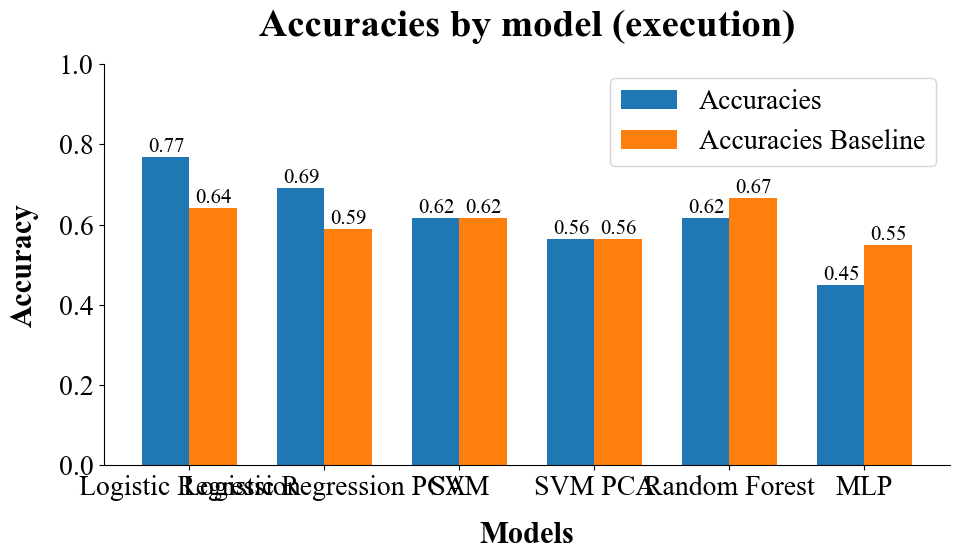

In [134]:
# General
plt.rcParams["font.family"] = "Times New Roman"
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE, titleweight = 'bold', titlepad = 20)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight = 'bold', labelpad = 15)   # fontsize of the x and y labels    
plt.rc('xtick', labelsize=SMALL_SIZE, direction = 'out')    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE, direction = 'out')    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes.spines', top=False, right=False)  # Removing the top and right spines   

models = accuracies_ex.keys()

dataset_values = [accuracies_ex[model] for model in models]
baseline_values = [accuracies_ex_baseline[model] for model in models]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width/2, dataset_values, width, label='Accuracies')
bars2 = ax.bar(x + width/2, baseline_values, width, label='Accuracies Baseline')

ax.set_xticks(x)
ax.set_xticklabels(models)

ax.set_ylabel('Accuracy')
ax.set_xlabel('Models')
ax.set_title('Accuracies by model (execution)')

ax.set_ylim(0,1)

ax.legend()

for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/8, yval, round(yval, 2), va='bottom', fontsize=15)
    
for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/8, yval, round(yval, 2), va='bottom', fontsize=15)
    
plt.tight_layout()
saved_dir = os.path.join(os.getcwd(), 'figures')
if not os.path.exists(saved_dir):
    os.makedirs(saved_dir)
plt.savefig('figures/accuracies_ex.png')
plt.show()


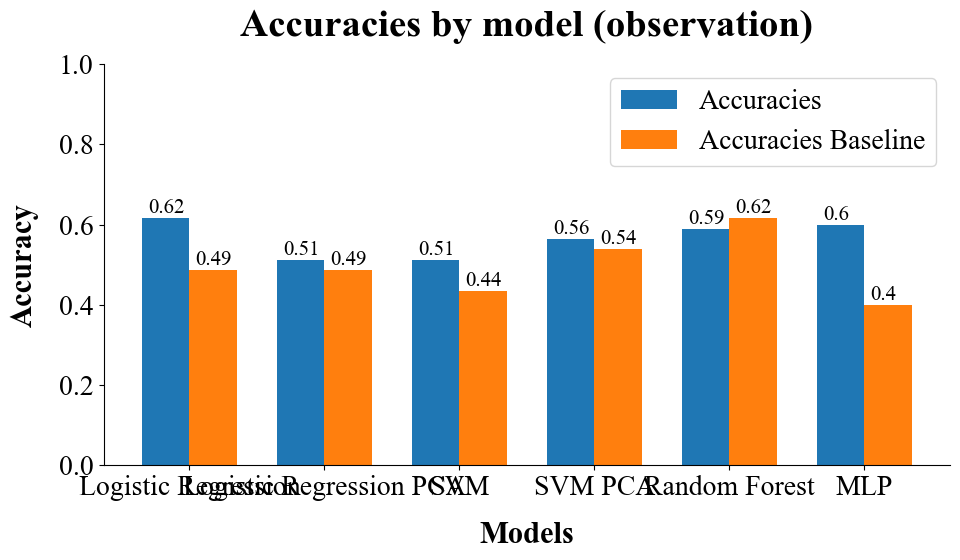

In [135]:
# General
plt.rcParams["font.family"] = "Times New Roman"
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE, titleweight = 'bold', titlepad = 20)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight = 'bold', labelpad = 15)   # fontsize of the x and y labels    
plt.rc('xtick', labelsize=SMALL_SIZE, direction = 'out')    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE, direction = 'out')    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes.spines', top=False, right=False)  # Removing the top and right spines   

models = accuracies_obs.keys()

dataset_values = [accuracies_obs[model] for model in models]
baseline_values = [accuracies_obs_baseline[model] for model in models]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width/2, dataset_values, width, label='Accuracies')
bars2 = ax.bar(x + width/2, baseline_values, width, label='Accuracies Baseline')

ax.set_xticks(x)
ax.set_xticklabels(models)

ax.set_ylabel('Accuracy')
ax.set_xlabel('Models')
ax.set_title('Accuracies by model (observation)')

ax.set_ylim(0,1)

ax.legend()

for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/8, yval, round(yval, 2), va='bottom', fontsize=15)
    
for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/8, yval, round(yval, 2), va='bottom', fontsize=15)
    
plt.tight_layout()
saved_dir = os.path.join(os.getcwd(), 'figures')
if not os.path.exists(saved_dir):
    os.makedirs(saved_dir)
plt.savefig('figures/accuracies_obs.png')
plt.show()
